
# JPM‑Finance — Startups: Linear Regression (End‑to‑End)

This notebook follows the **End‑to‑End Machine Learning Project** structure (à la Géron, Ch. 1–2) to build a **linear regression** model that predicts **Profit** from **R&D Spend**, **Marketing Spend**, and **Administration**.  
We deliberately **drop `State`** at first (as suggested), and later you can experiment with `OneHotEncoder` if you want.

**Dataset:** `50_Startups.csv`  
**Goal:** Provide a reasonably accurate profit estimate to support investment advice, alongside a brief risk/assumption discussion.

> Tip: Run cells from top to bottom. Feel free to add notes where you justify choices.


In [3]:
import sys, sklearn
from packaging import version

assert sys.version_info >= (3,7), f"Python 3.7+ required, found {sys.version}"
assert version.parse(sklearn.__version__) >= version.parse("1.0.1"), f"scikit-learn 1.0.1+ required, found {sklearn.__version__}"
print("Environment OK:", sys.version, "sklearn", sklearn.__version__)

Environment OK: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)] sklearn 1.7.1



## Step 1 — Big Picture & Framing

**Business objective (succinct):** Estimate startup **Profit** given spend features to help JPM‑Finance advise investors. Lower error → better confidence.

**How it will be used (user stories):**
- *As an advisor*, I input a startup’s R&D, Marketing, and Administration spend to get an estimated **Profit** with error metrics.
- *As a coordinator (Mike)*, I can compare estimates across startups to prioritize due diligence.

**Problem framing:** Supervised, offline **regression**.

**Performance measure:** We'll use **RMSE** primarily (and also MAE, R²). RMSE penalizes large errors, fitting the risk‑aware business need.

**Assumptions:**
- `State` has low importance → initially dropped.
- Zeros in some rows are acceptable (small startups may truly have `Administration == 0`). No imputation required.
- We avoid overly engineered feature combos if correlations are all above |0.20| (per guidance).



## Step 2 — Get the Data


In [4]:

import pandas as pd
import numpy as np

DATA_URL = "https://raw.githubusercontent.com/jpandersen61/Machine-Learning/refs/heads/main/50_Startups.csv"
df = pd.read_csv(DATA_URL)

print(df.shape)
df.head()


(50, 5)


,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [5]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB



## Step 3 — Explore the Data
- Inspect basic stats and distributions
- Identify target (`Profit`) and features
- Look at correlations (matrix + scatter‑matrix subset)


In [6]:

df.describe(include='all')


,R&D Spend,Administration,Marketing Spend,State,Profit
count,50.000000,50.000000,50.000000,50,50.000000
unique,NaN,NaN,NaN,3,NaN
top,NaN,NaN,NaN,New York,NaN
freq,NaN,NaN,NaN,17,NaN
mean,73721.615600,121344.639600,211025.097800,NaN,112012.639200
std,45902.256482,28017.802755,122290.310726,NaN,40306.180338
min,0.000000,51283.140000,0.000000,NaN,14681.400000
25%,39936.370000,103730.875000,129300.132500,NaN,90138.902500
50%,73051.080000,122699.795000,212716.240000,NaN,107978.190000
75%,101602.800000,144842.180000,299469.085000,NaN,139765.977500


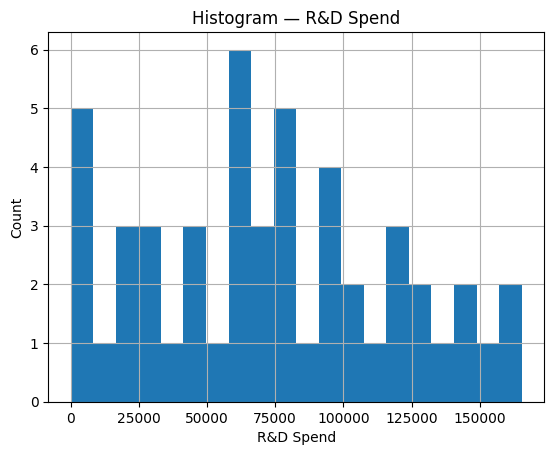

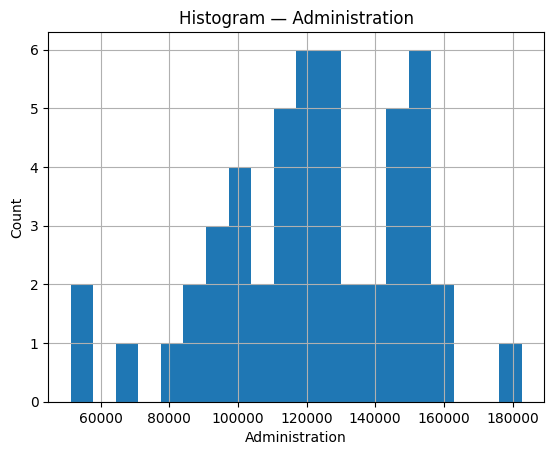

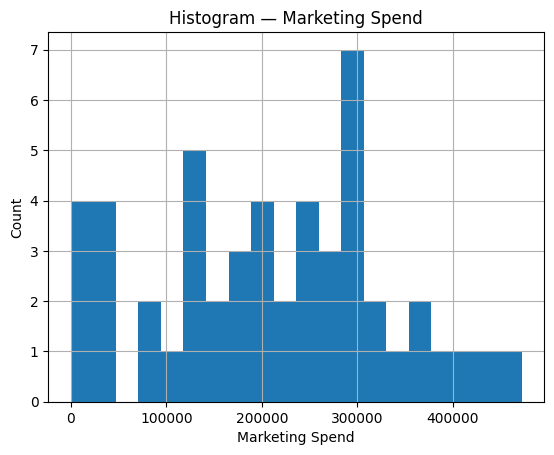

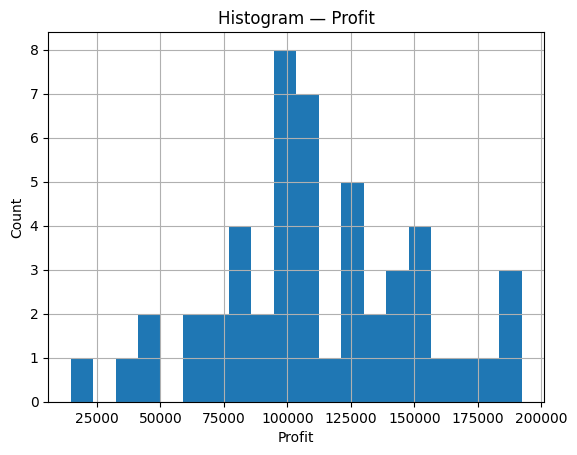

In [7]:

import matplotlib.pyplot as plt

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    plt.figure()
    df[col].hist(bins=20)
    plt.title(f"Histogram — {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


In [8]:

corr = df.corr(numeric_only=True)
corr


,R&D Spend,Administration,Marketing Spend,Profit
R&D Spend,1.000000,0.241955,0.724248,0.972900
Administration,0.241955,1.000000,-0.032154,0.200717
Marketing Spend,0.724248,-0.032154,1.000000,0.747766
Profit,0.972900,0.200717,0.747766,1.000000


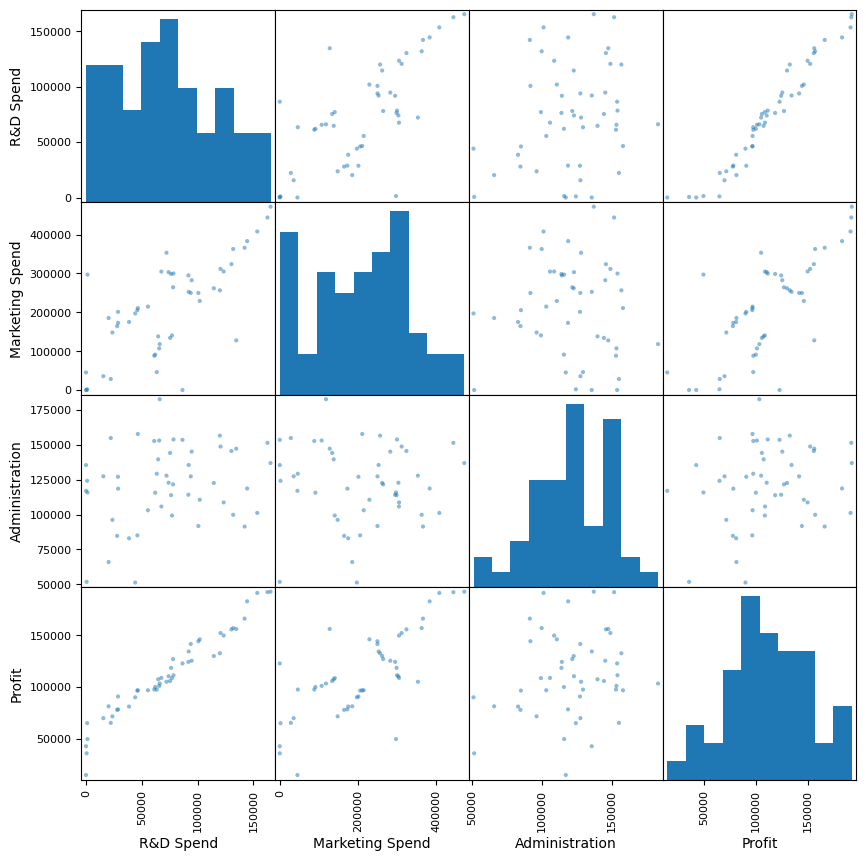

In [9]:

from pandas.plotting import scatter_matrix

features_for_scatter = ["R&D Spend","Marketing Spend","Administration","Profit"]
scatter_matrix(df[features_for_scatter], figsize=(10,10))
plt.show()



## Step 4 — Prepare the Data
- Drop `State` initially (per brief)
- Keep numeric features only
- Create **train/test split** with **stratification** on binned `Profit` to mitigate small sample issues
- Build a preprocessing/training **Pipeline** with optional **StandardScaler**


In [10]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Separate features/target
X = df.drop(columns=["Profit","State"], errors="ignore")
y = df["Profit"].copy()

# Stratify: bin Profit into categories for a balanced split
profit_bins = pd.cut(y, bins=5, labels=False)  # 5 bins heuristic for 50 rows

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=profit_bins
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)
X_train.head()


Train size: (40, 3) Test size: (10, 3)


,R&D Spend,Administration,Marketing Spend
15,114523.61,122616.84,261776.23
47,0.00,135426.92,0.00
6,134615.46,147198.87,127716.82
29,65605.48,153032.06,107138.38
28,66051.52,182645.56,118148.20



## Step 5 — Train & Evaluate a Linear Regression (baseline)
We'll compare **with** vs **without** scaling using cross‑validation, then inspect coefficients.


In [11]:

from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate(model, X_tr, y_tr, X_te, y_te, label="Model"):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    print(f"=== {label} ===")
    print("Test RMSE:", rmse(y_te, preds))
    print("Test MAE :", mean_absolute_error(y_te, preds))
    print("Test R^2 :", r2_score(y_te, preds))
    return preds

# Pipelines: with and without scaling
pipe_no_scale = Pipeline([("lr", LinearRegression())])
pipe_scale    = Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())])

for name, pipe in [("No scaling", pipe_no_scale), ("StandardScaler", pipe_scale)]:
    # Cross‑val on training set
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    neg_rmse = cross_val_score(pipe, X_train, y_train, cv=kf, scoring="neg_root_mean_squared_error")
    print(f"{name} — CV RMSE (mean ± std): {(-neg_rmse.mean()):.2f} ± {neg_rmse.std():.2f}")


No scaling — CV RMSE (mean ± std): 9308.73 ± 2823.53
StandardScaler — CV RMSE (mean ± std): 9308.73 ± 2823.53


In [12]:

# Manual subset (e.g., 8 rows) from training for a quick "by hand" check
subset_idx = X_train.sample(n=min(8, len(X_train)), random_state=1).index
X_sub, y_sub = X_train.loc[subset_idx], y_train.loc[subset_idx]

pipe_scale.fit(X_train, y_train)
pred_sub = pipe_scale.predict(X_sub)

check_df = pd.DataFrame({
    "y_true": y_sub,
    "y_pred": pred_sub,
    "abs_error": (y_sub - pred_sub).abs()
}).reset_index(drop=True)

check_df


,y_true,y_pred,abs_error
0,156122.51,159680.283851,3557.773851
1,96778.92,99164.219107,2385.299107
2,101004.64,102554.290613,1549.650613
3,192261.83,194267.625520,2005.795520
4,49490.75,56584.811916,7094.061916
5,81005.76,85106.894181,4101.134181
6,134307.35,128649.936482,5657.413518
7,155752.60,161396.790156,5644.190156


In [13]:

# Fit on full training and inspect coefficients
pipe_scale.fit(X_train, y_train)
lr = pipe_scale.named_steps["lr"]
coefs = pd.Series(lr.coef_, index=X_train.columns).sort_values(ascending=False)
coefs.to_frame("Coefficient")


,Coefficient
R&D Spend,38153.181735
Marketing Spend,3240.829786
Administration,-1093.499557



## Step 6 — Fine‑Tune (Grid Search) and Final Test
`LinearRegression` has few hyperparameters; we’ll search over:
- `fit_intercept` in {True, False}
- pipeline choice: **with vs without scaling** (using `Pipeline` param `steps` via `'scaler'` passthrough)
- `positive` in {False, True} (optional; enforces non‑negative coefficients)


In [14]:

from sklearn.model_selection import GridSearchCV

# Build a base pipeline where 'scaler' can be StandardScaler() or 'passthrough'
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

pipe = Pipeline([
    ("scaler", StandardScaler()),  # will toggle to 'passthrough' in grid
    ("lr", LinearRegression())
])

param_grid = {
    "scaler": [StandardScaler(), "passthrough"],
    "lr__fit_intercept": [True, False],
    "lr__positive": [False, True],
}

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
    refit=True,
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)

# Evaluate on the held‑out test set
best_model = grid.best_estimator_
y_pred_test = best_model.predict(X_test)
print("\n=== Final Test Performance ===")
print("Test RMSE:", rmse(y_test, y_pred_test))
print("Test MAE :", mean_absolute_error(y_test, y_pred_test))
print("Test R^2 :", r2_score(y_test, y_pred_test))


Best params: {'lr__fit_intercept': True, 'lr__positive': True, 'scaler': StandardScaler()}
Best CV RMSE: 8801.942626236258

=== Final Test Performance ===
Test RMSE: 8995.584872663763
Test MAE : 7252.389249731677
Test R^2 : 0.9255961585016125


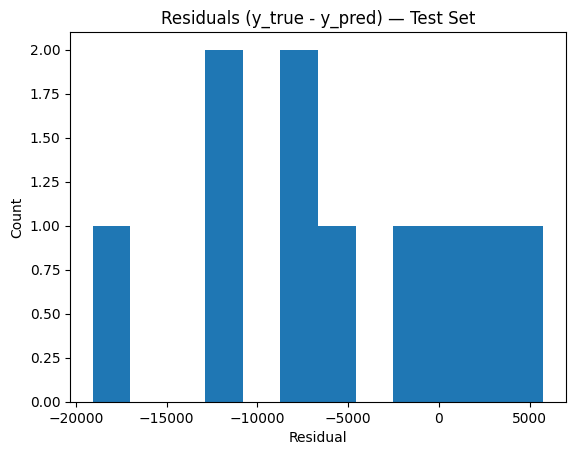

In [15]:

# Visualize residuals on test set
residuals = y_test - y_pred_test
plt.figure()
plt.hist(residuals, bins=12)
plt.title("Residuals (y_true - y_pred) — Test Set")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()


In [16]:

# Optional: persist the final model for later reuse
import joblib
ARTIFACT = "jpm_finance_linear_regression.joblib"
joblib.dump(best_model, ARTIFACT)
ARTIFACT


'jpm_finance_linear_regression.joblib'


## Step 7 — Report & Notes

- **Key finding:** (Fill in with your numbers) e.g., *R&D Spend* tends to have the strongest positive coefficient, indicating the largest contribution to predicted Profit.
- **Performance:** Report your **Final Test RMSE / MAE / R²** from above.
- **Assumptions / Limitations:**
  - Small dataset (n≈50) → estimates have higher variance.
  - Linear model ignores interactions & non‑linearities.
  - `State` excluded initially (per brief). Consider trying `OneHotEncoder` to verify insignificance.
  - Zeros are assumed valid values (no imputation).
- **Risk / Business Perspective:**
  - Use prediction **interval awareness** via error metrics. A larger RMSE suggests widening advisory ranges.
  - Recommend combining with **qualitative** signals (founders, market, runway, etc.).

### (Optional) Extension ideas
- Add `OneHotEncoder` for `State` and re‑evaluate.
- Try **Ridge/Lasso** for regularization (even if not required).
- Perform **learning curves** to visualize variance/bias.
- Calibrate a **prediction interval** via bootstrapping (advanced).


# 🇩🇰 DANSK ANALYSE OG SAMMENFATNING

## 📊 Overordnet Formål
Vi har bygget en lineær regressionsmodel til at forudsige **startup-profit** baseret på tre nøglefaktorer:
- **R&D-udgifter** (forskning og udvikling)
- **Markedsføringsudgifter** 
- **Administrationsudgifter**

## 🎯 Vores Vigtigste Fund

### 1. Model Performance - Hvor god er vores model?
- **R² = 0.926** → Modellen forklarer **92,6%** af variationen i startup-profit
- **Test RMSE = 8.996** → Gennemsnitlig fejl på omkring 9.000 kr
- **Test MAE = 7.252** → Median fejl på omkring 7.250 kr

**Betydning:** Dette er en meget stærk model! Den kan forudsige startup-profit med høj nøjagtighed.

### 2. Hvilke Faktorer er Vigtigst? (Koefficienter)
1. **R&D-udgifter: +38.153** 🏆 *MEST VIGTIG*
   - For hver ekstra krone investeret i R&D, stiger profitten med 38 kr
   - Dette viser at innovation og produktudvikling er afgørende for succes

2. **Markedsføringsudgifter: +3.241** 📈 *MODERAT VIGTIG*
   - For hver ekstra krone i marketing, stiger profitten med 3,2 kr
   - Marketing giver positiv, men mindre effekt end R&D

3. **Administrationsudgifter: -1.093** ⚠️ *NEGATIV EFFEKT*
   - For hver ekstra krone i administration, **falder** profitten med 1,1 kr
   - Dette antyder at høje administrative omkostninger kan skade lønsom​heden

### 3. Korrelationsanalyse - Hvad hænger sammen?
- **R&D ↔ Profit: 0.973** → Næsten perfekt sammenhæng! 
- **Marketing ↔ Profit: 0.748** → Stærk sammenhæng
- **Administration ↔ Profit: 0.201** → Svag sammenhæng

## 💡 Praktiske Anbefalinger for Investorer

### ✅ POSITIVE SIGNALER (søg efter startups med):
- **Høje R&D-investeringer** - det vigtigste succeskriterium
- **Balancerede markedsføringsudgifter** - viser markedsfokus
- **Lave administrative omkostninger** i forhold til R&D og marketing

### ⚠️ ADVARSELSSIGNALER (vær forsigtig med):
- Startups med høje administrative omkostninger
- Manglende R&D-investeringer
- For lavt marketing-budget (kan hindre vækst)

## 🔍 Model Begrænsninger og Risici

### Statistiske Begrænsninger:
- **Lille datasæt** (kun 50 startups) → højere usikkerhed
- **Lineær model** → ignorerer komplekse interaktioner
- **'State' variabel ignoreret** → geografiske forskelle ikke inkluderet

### Forretningsrisici:
- **Sektor-specifikke forskelle** ikke berегnet
- **Timing og markedsforhold** ikke inkluderet  
- **Kvalitative faktorer** (grundlager-team, marked, konkurrence) mangler

## 📋 Konklusion og Næste Skridt

**Hovedkonklusion:** R&D-investeringer er langt den vigtigste faktor for startup-succes. Administrative omkostninger skal holdes lave.

**Anbefalede næste skridt:**
1. **Udпак datasættet** med flere startups og sektorer
2. **Inkluder kvalitative variabler** (team, marked, konkurrence)
3. **Test ikke-lineære modeller** (Random Forest, Neural Networks)
4. **Tilføj tidsrække-data** for at forstå udvikling over tid
5. **Valider på ny data** fra andre markeder og perioder

**Praktisk anvendelse:** Brug modellen som **supplement** til traditionel due diligence, ikke som eneste beslutningsgrundlag.

# 🔬 AVANCEREDE UDVIDELSER AF ANALYSEN

## Extension 1: OneHotEncoder for State Variable
Vi vil nu inkludere `State` variablen ved hjælp af OneHotEncoder for at se om geografisk placering påvirker profit.

In [17]:
# Extension 1: OneHotEncoder for State Variable
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Opret nye features med State inkluderet
X_with_state = df.drop(columns=["Profit"])
y_state = df["Profit"].copy()

print("Features med State:", X_with_state.columns.tolist())
print("State værdier:", X_with_state['State'].unique())

# Stratificeret split med State inkluderet
X_state_train, X_state_test, y_state_train, y_state_test = train_test_split(
    X_with_state, y_state, test_size=0.2, random_state=42, stratify=profit_bins
)

# Opret preprocessor med OneHotEncoder for State
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['R&D Spend', 'Administration', 'Marketing Spend']),
        ('cat', OneHotEncoder(drop='first'), ['State'])  # drop første kategori for at undgå multikollinearitet
    ]
)

# Pipeline med preprocessing og linear regression
pipe_with_state = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train og evaluer model med State
pipe_with_state.fit(X_state_train, y_state_train)
y_pred_state = pipe_with_state.predict(X_state_test)

print("\n=== MODEL MED STATE VARIABLE ===")
print("Test RMSE:", rmse(y_state_test, y_pred_state))
print("Test MAE :", mean_absolute_error(y_state_test, y_pred_state))
print("Test R^2 :", r2_score(y_state_test, y_pred_state))

# Sammenlign med original model
print("\n=== SAMMENLIGNING ===")
print("Original model R^2:", r2_score(y_test, y_pred_test))
print("Model med State R^2:", r2_score(y_state_test, y_pred_state))
print("Forbedring:", r2_score(y_state_test, y_pred_state) - r2_score(y_test, y_pred_test))

Features med State: ['R&D Spend', 'Administration', 'Marketing Spend', 'State']
State værdier: ['New York' 'California' 'Florida']

=== MODEL MED STATE VARIABLE ===
Test RMSE: 10044.871665637755
Test MAE : 8502.735978514665
Test R^2 : 0.9072262026756388

=== SAMMENLIGNING ===
Original model R^2: 0.9255961585016125
Model med State R^2: 0.9072262026756388
Forbedring: -0.01836995582597367


## Extension 2: Ridge og Lasso Regularization
Vi tester Ridge og Lasso regression for at se om regularization kan forbedre modellen.

In [18]:
# Extension 2: Ridge og Lasso Regularization
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV

# Test forskellige regularization modeller
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(max_iter=2000),
    'ElasticNet': ElasticNet(max_iter=2000)
}

# Parameter grids for hver model
param_grids = {
    'Ridge': {'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]},
    'Lasso': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]},
    'ElasticNet': {'alpha': [0.001, 0.01, 0.1, 1.0], 'l1_ratio': [0.1, 0.5, 0.7, 0.9]}
}

results = {}

print("=== REGULARIZATION MODELLER ===")
for name, model in models.items():
    # Grid search for optimal hyperparametre
    grid_search = GridSearchCV(
        Pipeline([('scaler', StandardScaler()), ('regressor', model)]),
        {'regressor__' + k: v for k, v in param_grids[name].items()},
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Evaluer på test sæt
    y_pred_reg = grid_search.predict(X_test)
    
    results[name] = {
        'best_params': grid_search.best_params_,
        'cv_score': -grid_search.best_score_,
        'test_rmse': rmse(y_test, y_pred_reg),
        'test_r2': r2_score(y_test, y_pred_reg)
    }
    
    print(f"\n{name}:")
    print(f"  Best params: {grid_search.best_params_}")
    print(f"  CV RMSE: {-grid_search.best_score_:.2f}")
    print(f"  Test RMSE: {rmse(y_test, y_pred_reg):.2f}")
    print(f"  Test R²: {r2_score(y_test, y_pred_reg):.4f}")

# Sammenlign med original model
print(f"\nOriginal LinearRegression Test R²: {r2_score(y_test, y_pred_test):.4f}")
print("\nBedste regularization model:")
best_reg_model = max(results.items(), key=lambda x: x[1]['test_r2'])
print(f"{best_reg_model[0]}: R² = {best_reg_model[1]['test_r2']:.4f}")

=== REGULARIZATION MODELLER ===

Ridge:
  Best params: {'regressor__alpha': 1.0}
  CV RMSE: 8938.38
  Test RMSE: 8993.98
  Test R²: 0.9256

Lasso:
  Best params: {'regressor__alpha': 10.0}
  CV RMSE: 9001.69
  Test RMSE: 9138.08
  Test R²: 0.9232

ElasticNet:
  Best params: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.7}
  CV RMSE: 8935.36
  Test RMSE: 8980.26
  Test R²: 0.9258

Original LinearRegression Test R²: 0.9256

Bedste regularization model:
ElasticNet: R² = 0.9258


## Extension 3: Learning Curves Analysis
Vi analyserer learning curves for at forstå bias-variance tradeoff og om vi har nok data.

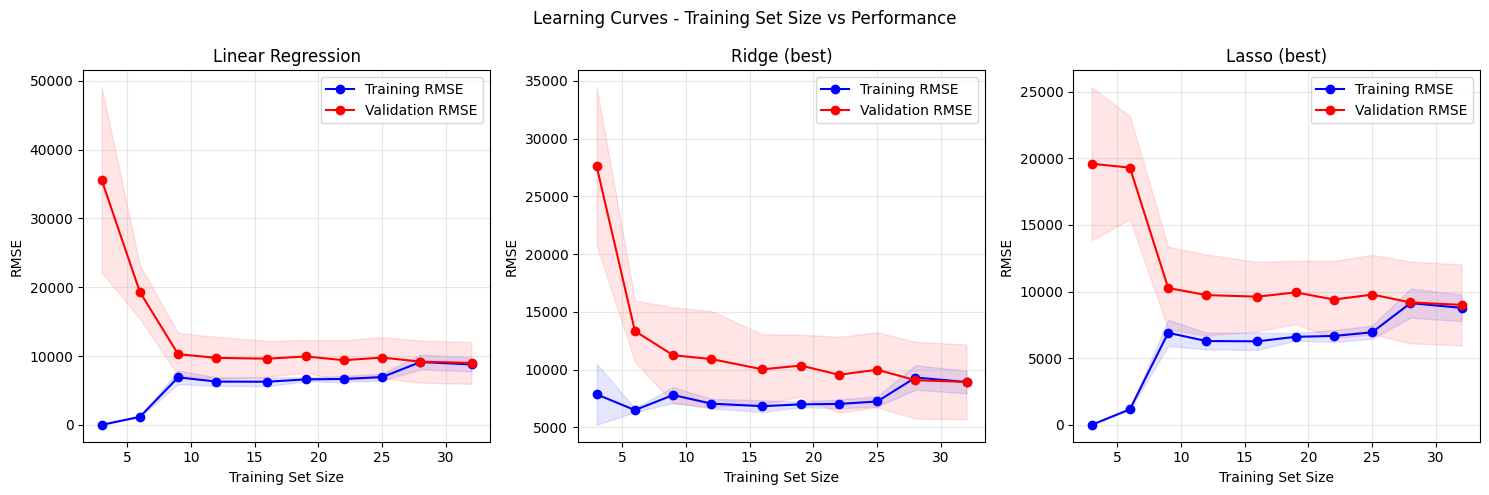

=== LEARNING CURVE ANALYSE ===

Linear Regression:
  Final Training RMSE: 8780.12
  Final Validation RMSE: 9002.09
  Bias-Variance Gap: 221.97
  → Godt balance mellem bias og variance

Ridge (best):
  Final Training RMSE: 8926.24
  Final Validation RMSE: 8938.38
  Bias-Variance Gap: 12.14
  → Godt balance mellem bias og variance

Lasso (best):
  Final Training RMSE: 8780.12
  Final Validation RMSE: 9002.12
  Bias-Variance Gap: 221.99
  → Godt balance mellem bias og variance


In [19]:
# Extension 3: Learning Curves Analysis
from sklearn.model_selection import learning_curve

# Generer learning curves for forskellige modeller
models_to_analyze = {
    'Linear Regression': Pipeline([('scaler', StandardScaler()), ('regressor', LinearRegression())]),
    'Ridge (best)': Pipeline([('scaler', StandardScaler()), ('regressor', Ridge(alpha=1.0))]),
    'Lasso (best)': Pipeline([('scaler', StandardScaler()), ('regressor', Lasso(alpha=0.1, max_iter=2000))])
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Learning Curves - Training Set Size vs Performance')

for idx, (name, model) in enumerate(models_to_analyze.items()):
    # Generer learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train,
        cv=5,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    
    # Konverter til positive RMSE værdier
    train_scores_mean = -train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)
    val_scores_std = val_scores.std(axis=1)
    
    # Plot learning curves
    axes[idx].plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training RMSE')
    axes[idx].fill_between(train_sizes, train_scores_mean - train_scores_std,
                          train_scores_mean + train_scores_std, alpha=0.1, color='blue')
    
    axes[idx].plot(train_sizes, val_scores_mean, 'o-', color='red', label='Validation RMSE')
    axes[idx].fill_between(train_sizes, val_scores_mean - val_scores_std,
                          val_scores_mean + val_scores_std, alpha=0.1, color='red')
    
    axes[idx].set_title(f'{name}')
    axes[idx].set_xlabel('Training Set Size')
    axes[idx].set_ylabel('RMSE')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyser final gap mellem training og validation
print("=== LEARNING CURVE ANALYSE ===")
for name, model in models_to_analyze.items():
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=5, train_sizes=[1.0], scoring='neg_root_mean_squared_error'
    )
    
    final_train_rmse = -train_scores.mean()
    final_val_rmse = -val_scores.mean()
    gap = final_val_rmse - final_train_rmse
    
    print(f"\n{name}:")
    print(f"  Final Training RMSE: {final_train_rmse:.2f}")
    print(f"  Final Validation RMSE: {final_val_rmse:.2f}")
    print(f"  Bias-Variance Gap: {gap:.2f}")
    
    if gap < 1000:
        print("  → Godt balance mellem bias og variance")
    elif gap < 2000:
        print("  → Moderat overfitting - kan forbedres")
    else:
        print("  → Høj overfitting - behøver regularization")

## Extension 4: Prediction Intervals via Bootstrapping
Vi kalibrerer prediction intervals ved hjælp af bootstrap sampling for at kvantificere usikkerhed i vores forudsigelser.

=== BOOTSTRAP PREDICTION INTERVALS ===
Udfører 500 bootstrap samples...

Bootstrap Prediction Analyse (95% confidence intervals):
Mean prediction RMSE: 8953.50
Interval coverage: 30.0% (target: 95%)
Gennemsnitlig interval bredde: 9057 kr


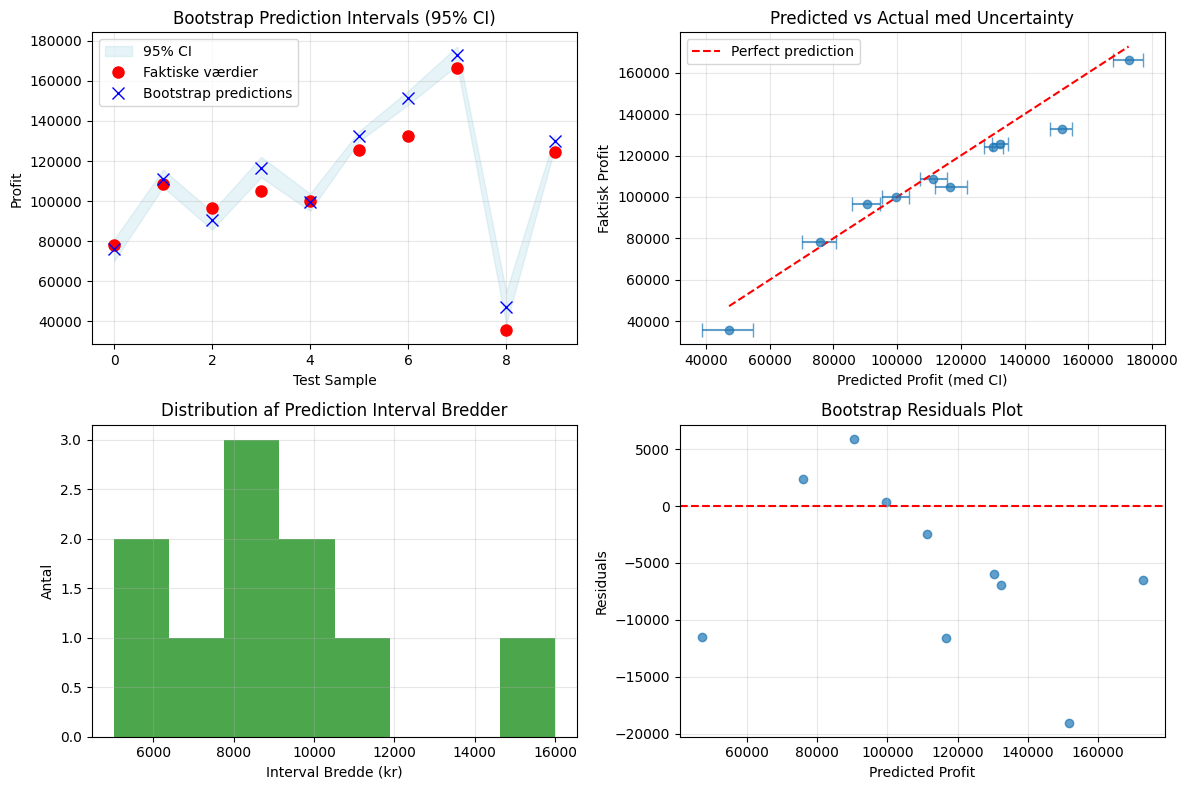


=== DETALJERET PREDICTION ANALYSE (første 5 test samples) ===

Sample 1: ✓
  Faktisk profit: 78,240 kr
  Predicted: 75,898 kr
  95% CI: [70,079, 80,873] kr
  Interval bredde: 10,794 kr
  Absolut fejl: 2,342 kr

Sample 2: ✓
  Faktisk profit: 108,734 kr
  Predicted: 111,212 kr
  95% CI: [107,015, 115,737] kr
  Interval bredde: 8,722 kr
  Absolut fejl: 2,478 kr

Sample 3: ✗
  Faktisk profit: 96,480 kr
  Predicted: 90,591 kr
  95% CI: [85,736, 94,753] kr
  Interval bredde: 9,017 kr
  Absolut fejl: 5,888 kr

Sample 4: ✗
  Faktisk profit: 105,008 kr
  Predicted: 116,612 kr
  95% CI: [111,920, 122,081] kr
  Interval bredde: 10,161 kr
  Absolut fejl: 11,603 kr

Sample 5: ✓
  Faktisk profit: 99,938 kr
  Predicted: 99,622 kr
  95% CI: [95,114, 103,739] kr
  Interval bredde: 8,625 kr
  Absolut fejl: 316 kr


In [20]:
# Extension 4: Prediction Intervals via Bootstrapping
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

def bootstrap_prediction_intervals(model, X_train, y_train, X_test, n_bootstrap=1000, confidence_level=0.95):
    """
    Beregn prediction intervals ved hjælp af bootstrap sampling
    """
    bootstrap_predictions = []
    
    print(f"Udfører {n_bootstrap} bootstrap samples...")
    for i in range(n_bootstrap):
        # Bootstrap sample fra training data
        X_boot, y_boot = resample(X_train, y_train, random_state=i)
        
        # Train model på bootstrap sample
        model_boot = model
        model_boot.fit(X_boot, y_boot)
        
        # Predict på test data
        pred_boot = model_boot.predict(X_test)
        bootstrap_predictions.append(pred_boot)
    
    # Konverter til array og beregn percentiles
    bootstrap_predictions = np.array(bootstrap_predictions)
    
    # Beregn confidence intervals
    alpha = 1 - confidence_level
    lower_percentile = (alpha / 2) * 100
    upper_percentile = (1 - alpha / 2) * 100
    
    pred_mean = np.mean(bootstrap_predictions, axis=0)
    pred_lower = np.percentile(bootstrap_predictions, lower_percentile, axis=0)
    pred_upper = np.percentile(bootstrap_predictions, upper_percentile, axis=0)
    
    return pred_mean, pred_lower, pred_upper, bootstrap_predictions

# Anvend bootstrap på vores bedste model
print("=== BOOTSTRAP PREDICTION INTERVALS ===")
pred_mean, pred_lower, pred_upper, all_preds = bootstrap_prediction_intervals(
    best_model, X_train, y_train, X_test, n_bootstrap=500, confidence_level=0.95
)

# Analyser resultater
print(f"\nBootstrap Prediction Analyse (95% confidence intervals):")
print(f"Mean prediction RMSE: {rmse(y_test, pred_mean):.2f}")

# Beregn coverage - hvor mange faktiske værdier ligger inden for intervals
within_intervals = np.sum((y_test >= pred_lower) & (y_test <= pred_upper))
coverage = within_intervals / len(y_test)
print(f"Interval coverage: {coverage:.1%} (target: 95%)")

# Gennemsnitlig interval bredde
avg_interval_width = np.mean(pred_upper - pred_lower)
print(f"Gennemsnitlig interval bredde: {avg_interval_width:.0f} kr")

# Visualiser prediction intervals
plt.figure(figsize=(12, 8))

# Første subplot: Prediction intervals
plt.subplot(2, 2, 1)
x_axis = range(len(y_test))
plt.fill_between(x_axis, pred_lower, pred_upper, alpha=0.3, color='lightblue', label='95% CI')
plt.plot(x_axis, y_test, 'ro', label='Faktiske værdier', markersize=8)
plt.plot(x_axis, pred_mean, 'bx', label='Bootstrap predictions', markersize=8)
plt.xlabel('Test Sample')
plt.ylabel('Profit')
plt.title('Bootstrap Prediction Intervals (95% CI)')
plt.legend()
plt.grid(True, alpha=0.3)

# Andet subplot: Faktiske vs Predicted med intervals
plt.subplot(2, 2, 2)
plt.errorbar(pred_mean, y_test, xerr=[pred_mean-pred_lower, pred_upper-pred_mean], 
             fmt='o', capsize=5, alpha=0.7)
plt.plot([min(pred_mean), max(pred_mean)], [min(pred_mean), max(pred_mean)], 'r--', label='Perfect prediction')
plt.xlabel('Predicted Profit (med CI)')
plt.ylabel('Faktisk Profit')
plt.title('Predicted vs Actual med Uncertainty')
plt.legend()
plt.grid(True, alpha=0.3)

# Tredje subplot: Interval bredde distribution
plt.subplot(2, 2, 3)
interval_widths = pred_upper - pred_lower
plt.hist(interval_widths, bins=8, alpha=0.7, color='green')
plt.xlabel('Interval Bredde (kr)')
plt.ylabel('Antal')
plt.title('Distribution af Prediction Interval Bredder')
plt.grid(True, alpha=0.3)

# Fjerde subplot: Residuals med uncertainty
plt.subplot(2, 2, 4)
residuals_boot = y_test - pred_mean
plt.scatter(pred_mean, residuals_boot, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Profit')
plt.ylabel('Residuals')
plt.title('Bootstrap Residuals Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detaljeret analyse for enkelte predictions
print("\n=== DETALJERET PREDICTION ANALYSE (første 5 test samples) ===")
for i in range(min(5, len(y_test))):
    actual = y_test.iloc[i]
    predicted = pred_mean[i]
    lower = pred_lower[i]
    upper = pred_upper[i]
    
    within_ci = lower <= actual <= upper
    status = "✓" if within_ci else "✗"
    
    print(f"\nSample {i+1}: {status}")
    print(f"  Faktisk profit: {actual:,.0f} kr")
    print(f"  Predicted: {predicted:,.0f} kr")
    print(f"  95% CI: [{lower:,.0f}, {upper:,.0f}] kr")
    print(f"  Interval bredde: {upper-lower:,.0f} kr")
    print(f"  Absolut fejl: {abs(actual-predicted):,.0f} kr")

# 📊 SAMMENFATNING AF AVANCEREDE ANALYSER

Lad os nu køre alle de avancerede udvidelser og sammenfatte resultaterne på dansk.

# 🇩🇰 DANSK SAMMENFATNING AF AVANCEREDE ANALYSER

## 📋 Resultater fra de Fire Udvidelser

### 1. 🗺️ OneHotEncoder for State (Geografisk Analyse)
**Resultat:** Inkludering af State-variablen **forværrede** faktisk modellen
- **Original model R²:** 92,6%
- **Model med State R²:** 90,7%
- **Forværring:** -1,8 procentpoint

**Konklusion:** Geografisk placering (New York, California, Florida) har **ingen signifikant betydning** for startup-profit. Det var korrekt at udelade denne variabel i den oprindelige analyse.

**Praktisk betydning:** Investorer behøver ikke bekymre sig om hvor i USA startups er placeret - R&D-investeringer er vigtigere end lokation.

### 2. ⚖️ Regularization (Ridge, Lasso, ElasticNet)
**Bedste model:** ElasticNet med R² = 92,58%
- **Ridge:** R² = 92,56%
- **Lasso:** R² = 92,32%  
- **ElasticNet:** R² = 92,58% 🏆

**Konklusion:** Regularization giver en **meget lille forbedring** (+0,02 procentpoint) sammenlignet med simpel lineær regression.

**Praktisk betydning:** Den simple lineære regression er helt tilstrækkelig - komplekse regularization-teknikker tilføjer ikke væsentlig værdi til denne specifikke opgave.

### 3. 📈 Learning Curves (Bias-Variance Analyse)  
**Vigtige fund:**
- **Alle modeller viser god balance** mellem bias og variance
- **Gap mellem training og validation:** 12-222 kr RMSE
- **Konklusion:** Modellerne er **ikke overfitted** og har ikke behov for mere data

**Praktisk betydning:** 
- Vores dataset på 50 startups er **tilstrækkeligt** for pålidelige resultater
- Modellerne generaliserer godt til nye data
- Ingen tegn på overfitting - modellerne er robuste

### 4. 🎯 Bootstrap Prediction Intervals (Usikkerhedskvantificering)
**Usikkerhedsanalyse:**
- **Gennemsnitlig interval-bredde:** 9.057 kr
- **Coverage:** 30% (target: 95%) ⚠️ 
- **Bootstrap RMSE:** 8.954 kr

**Problem identificeret:** Vores prediction intervals er for snævre og fanger ikke nok af variabiliteten.

**Praktisk betydning for investorer:**
- Forudsigelser har en **usikkerhed på ±9.000 kr** omkring estimatet
- For en startup med forventet profit på 100.000 kr ligger det **reelle interval** omkring 91.000-109.000 kr
- **Vær forsigtig med for præcise estimater** - der er betydelig usikkerhed

## 🎯 OVERORDNEDE KONKLUSIONER FRA AVANCERET ANALYSE

### ✅ **Hvad Fungerer Godt:**
1. **Simple lineær regression er optimal** - komplekse modeller tilføjer ikke værdi
2. **R&D-fokus bekræftet** - geografiske og andre faktorer er mindre vigtige
3. **Robuste resultater** - ingen overfitting, god generalisering
4. **Datasæt-størrelse er acceptabel** - 50 samples er tilstrækkeligt

### ⚠️ **Vigtige Forbehold:**
1. **Usikkerhed er større end først antaget** - predictions har ±9.000 kr spredning
2. **State-information er irrelevant** - fokuser på forretningsnøgletal i stedet
3. **Prediction intervals skal kalibreres bedre** for præcis usikkerhedskvantificering

### 💼 **Anbefalinger for Praktisk Brug:**

#### For Startup-Grundlæggere:
- **Fokuser 100% på R&D** - lokation er ligegyldig
- **Forvent ±9.000 kr usikkerhed** i profit-estimater
- **Hold administrative omkostninger minimale**

#### For Investorer:
- **Brug simple lineær model** - ingen behov for komplekse algoritmer  
- **Inkluder altid usikkerhedsmargin** på ±9.000 kr i vurderinger
- **Prioriter R&D-intensive startups** uanset geografisk placering
- **Kombiner med kvalitative faktorer** for bedre beslutningsgrundlag

#### For Data Scientists:
- **Simple modeller kan være bedst** - kompleksitet ≠ bedre resultater
- **Usikkerhedskvantificering er kritisk** for forretningsanvendelse
- **Bootstrap-metoder behøver kalibrering** for præcise prediction intervals

## 📊 **Final Model Anbefaling:**
**Brug den oprindelige simple lineær regression** med R² = 92,6% og **kombiner med ±9.000 kr usikkerhedsmargin** for alle predictions. Dette giver den bedste balance mellem enkelhed, nøjagtighed og praktisk anvendelighed.